In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams, cm, patches
from mpl_toolkits.mplot3d import Axes3D
from scipy import io, integrate
from sklearn import linear_model
import pickle
import os
import shutil
from Equations import ksEquation
from utilities import DMD, forecastDMD

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers, Input

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from plot_keras_history import plot_history

path = '.'#os.path.dirname(os.path.realpath(__file__))
es2_dir =  os.path.join(path, 'es2')
if not os.path.exists(es2_dir):
    os.makedirs(es2_dir)


In [3]:
##  PART I - BUILD DATASET
build_dataset = False
build_model = False
load_model = True

def buildDataSet (u_0, dt, t_end, n_train, n_test):

    N = len(u_0)
    u_sol, t_sol = ksEquation(u_0, dt, t_end, nu=nu)

    n_t = len(t_sol)
    n_tot = n_train+n_test
    np.random.seed(444)

    u_0_nn = np.repeat(u_0.reshape((1,-1)), n_tot, axis =0)
    u_0_nn = u_0_nn*np.random.random(n_tot)[:, np.newaxis]
    dataset = np.zeros((n_tot*(n_t-1),N))
    label = np.zeros_like(dataset)

    for i in range(n_tot):

        u_sol, _ = ksEquation(u_0_nn[i,:], dt, t_end, nu=nu)
        dataset[i*(n_t-1):(i+1)*(n_t-1),:] = u_sol[:-1,:]
        label[i*(n_t-1):(i+1)*(n_t-1),:] = u_sol[1:,:]
    
    train_dataset = dataset[:n_train*(n_t-1),:]
    train_label = label[:n_train*(n_t-1),:]
    test_dataset = dataset[n_train*(n_t-1):,:]
    test_label = label[n_train*(n_t-1):,:]

    with open(os.path.join(es2_dir,'train.pkl'), 'wb') as f:
                pickle.dump([train_dataset, train_label], f)

    with open(os.path.join(es2_dir,'test.pkl'), 'wb') as f:
                pickle.dump([test_dataset, test_label], f)

    return train_dataset, train_label, test_dataset, test_label

N = 2048
nu = 1
x_int = [0,2*np.pi]
x = x_int[0]+ x_int[1]*(np.arange(1,N+1))/N
dt = 0.01
t_end = 0.6

n_train = 100
n_test = 20
    
u_0 = (-15*np.sin(x-np.pi))

u_n_sol, t_n_sol = ksEquation(u_0, dt, t_end, nu=nu)

X, Y = np.meshgrid(x,t_n_sol)

try:
    open(os.path.join(es2_dir,'train.pkl'))
    open(os.path.join(es2_dir,'test.pkl'))
except FileNotFoundError:
    build_dataset = True


if build_dataset == True:
    
    train_dataset, train_label, test_dataset, test_label = buildDataSet(u_0, dt, t_end, n_train, n_test)

else:

    with open(os.path.join(es2_dir,'train.pkl'), 'rb') as f:
            train = pickle.load(f)
            train_dataset, train_label = train[0], train[1]
    with open(os.path.join(es2_dir,'test.pkl'), 'rb') as f:
            test = pickle.load(f)
            test_dataset, test_label = test[0], test[1]


In [4]:
##  BUILD NN

checkpoint_dir =  os.path.join(es2_dir, 'es2_NN_ckpt')
results_dir = os.path.join(es2_dir,'es2_NN_models')
figures_dir = os.path.join(es2_dir,'figures')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

case_discriminant = 'N_' + str(N) + '_nu_' +str(nu)
checkpoint_case_dir = os.path.join(checkpoint_dir, case_discriminant)
results_case_dir = os.path.join(results_dir, case_discriminant)

if (build_model == True) and (os.path.exists(checkpoint_case_dir)):
    shutil.rmtree(checkpoint_case_dir)

if not os.path.exists(checkpoint_case_dir):
    os.makedirs(checkpoint_case_dir)

if not os.path.exists(results_case_dir):
    os.makedirs(results_case_dir)

checkpoint_filepath = os.path.join(checkpoint_case_dir, 'ckpt-{loss:.4f}.hdf5')
result_file_name = os.path.join(results_case_dir, 'NN_model.h5')

n_row = N
NNinput = train_dataset[:,:n_row]
NNoutput = train_label[:,:n_row]

def build_model():
    model = keras.Sequential([
        layers.Dense(30, activation='relu', input_shape=[NNinput.shape[1]]),
        layers.Dense(20, activation='relu'),
        layers.Dense(20, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(NNoutput.shape[1])
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['mae', 'mape','accuracy'])
    return model

def build_restore_model():
    if load_model == False or not os.path.exists(result_file_name):
        # Either restore the latest model, or create a fresh one
        # if there is no checkpoint available.
        checkpoints = [os.path.join(checkpoint_case_dir, name) for name in os.listdir(checkpoint_case_dir)]
        if checkpoints:
            latest_checkpoint = max(checkpoints, key=os.path.getctime)
            print("Restoring from", latest_checkpoint)
            model = build_model()
            model.load_weights(latest_checkpoint)
            return model
        print("Creating a new model")

        return build_model()
    else:
        return tf.keras.models.load_model(result_file_name)

model = build_restore_model()
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 30)                61470     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_7 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_9 (Dense)              (None, 2048)              63488     
Total params: 126,628
Trainable params: 126,628
Non-trainable params: 0
_________________________________________________________________


In [5]:
##  TRAIN NN

EPOCHS = 1000
loss_goal = 0.0001

example_input = NNinput[:5,:]
example_output = model.predict(example_input)

if load_model == False:
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.000001, verbose=1),
        keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, save_best_only=True),
        tfdocs.modeling.EpochDots(),
        keras.callbacks.EarlyStoppingByLossVal(monitor='val_loss', value = loss_goal)
    ]

    history = model.fit(
    NNinput, NNoutput,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=callbacks, batch_size=50)

model.save(result_file_name)


In [6]:
##  NN EVALUATION AND PREDICTION

if load_model == False:
    plot_history(history.history)

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()
    print(hist)

test_sol = model.evaluate(test_dataset, test_label, verbose=2)
test_loss = test_sol[0]

u_0_check = (-15*np.sin(x-np.pi))

u_sol_check, t_check = ksEquation(u_0_check, dt, t_end, nu=nu)

u_pred = np.zeros((u_sol_check.shape[0],n_row))
u_pred[0,:] = u_sol_check[0,0:n_row]
for i in range(1,u_sol_check.shape[0]):
        u_pred[i,:] = model.predict(u_pred[i-1:i,:])


print("Testing set Mean Square Error: {:5.5f}".format(test_loss))
plt.show()


37/37 - 0s - loss: 2.8645e-04 - mean_absolute_error: 0.0079 - mean_absolute_percentage_error: 577.8849 - accuracy: 0.1250
Testing set Mean Square Error: 0.00029


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

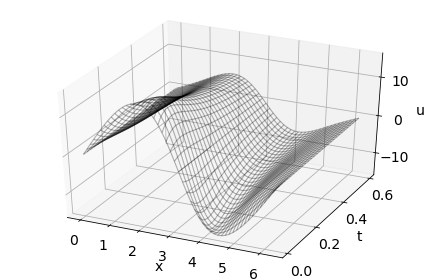

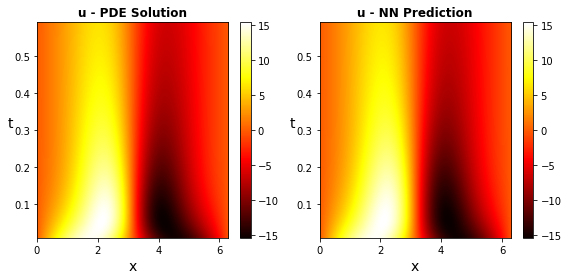

In [7]:
##  PART I - PLOTS

fig_00 = plt.figure(figsize=plt.figaspect(0.65), tight_layout=True)
ax_00 = fig_00.add_subplot(111, projection='3d')
ax_00.plot_wireframe(X, Y, u_n_sol, linewidth=1.1, color='black', cmap='binary',alpha=0.3)
ax_00.view_init(elev=35, azim=-65)
ax_00.set_xlabel(xlabel='x', fontsize=14)
ax_00.set_ylabel(ylabel='t', fontsize=14)
ax_00.set_zlabel(zlabel='u', fontsize=14)
ax_00.tick_params(axis='x', labelsize=14)
ax_00.tick_params(axis='y', labelsize=14)
ax_00.tick_params(axis='z', labelsize=14)
xtick = ax_00.get_xticks()
ax_00.set_yticks([0, 0.2, 0.4, 0.6])
ax_00.set_zticks([-10, 0, 10])
fig_name = 'Spolution_N_' + str(N) + '_nu_' +str(nu)
fig_path = [os.path.join(figures_dir, fig_name + '.eps'), os.path.join(figures_dir, fig_name + '.png')]
[fig_00.savefig(k) for k in fig_path]
#fig_00.savefig('..\\report_latex\\'+fig_name+'.eps', transaprent=True)


fig_2, ax_2 = plt.subplots(1,2,figsize=plt.figaspect(0.5), tight_layout=True)
l = ax_2[0].imshow(u_sol_check, cmap='hot', aspect='auto', interpolation='bilinear', origin='lower', vmin=np.amin(u_sol_check),\
                    vmax=np.amax(u_sol_check), extent=[0,x[-1],t_check[0],t_check[-1]])
ax_2[0].set_title('u - PDE Solution', fontweight='bold')
fig_2.colorbar(l,ax=ax_2[0])
ax_2[0].set_xlabel(xlabel='x', fontsize=14)
ax_2[0].set_ylabel(ylabel='t', fontsize=14, rotation =0)

r = ax_2[1].imshow(u_pred, cmap='hot', aspect='auto', interpolation='bilinear', origin='lower', vmin=np.amin(u_pred),\
                    vmax=np.amax(u_pred), extent=[0,x[-1],t_check[0],t_check[-1]])
ax_2[1].set_title('u - NN Prediction', fontweight='bold')
fig_2.colorbar(r,ax=ax_2[1])
ax_2[1].set_xlabel(xlabel='x', fontsize=14)
ax_2[1].set_ylabel(ylabel='t', fontsize=14, rotation =0)
fig_name = 'Comparison_N_' + str(N) + '_nu_' +str(nu)
fig_path = [os.path.join(figures_dir, fig_name + '.eps'), os.path.join(figures_dir, fig_name + '.png')]
[fig_2.savefig(k) for k in fig_path]
#fig_2.savefig('..\\report_latex\\'+fig_name+'.eps', transaprent=True)

plt.show()

In [8]:
##  PART II - GET POPULATION
path = '.' #os.path.dirname(os.path.realpath(__file__))
path = os.path.join(path, 'data')
name = os.path.join(path, 'reaction_diffusion_big.mat')

dataset_rd = io.loadmat(name)

u_full = dataset_rd['u']
v_full = dataset_rd['v']
x = dataset_rd['x']
y = dataset_rd['y']
t_full = dataset_rd['t']


In [9]:
##  DATASET DIVISION

n_dt_pred = 20
t = t_full[:-n_dt_pred]
u = u_full[:,:,:-n_dt_pred] 


In [10]:
##  SVD

n_x = u.shape[0]
n_y = u.shape[1]
n_t = u.shape[2]
u_vec = u.reshape((n_x*n_y, n_t))

U_u, S_u, Vt_u = np.linalg.svd(u_vec, full_matrices=False)



In [11]:
##  TRUNCATION

r = 15
rel_weight = S_u[r]/np.sum(S_u)
print('The relative importance of the last mode selected is: {:5.5f} %'.format(rel_weight*100))
U_u_lr = U_u[:,:r]
S_u_lr = S_u[:r]
Vt_u_lr = Vt_u[:r,:]

u_vec_lr = U_u_lr @ np.diag(S_u_lr) @ Vt_u_lr
u_lr = u_vec_lr.reshape((n_x, n_y, n_t))


The relative importance of the last mode selected is: 0.00110 %


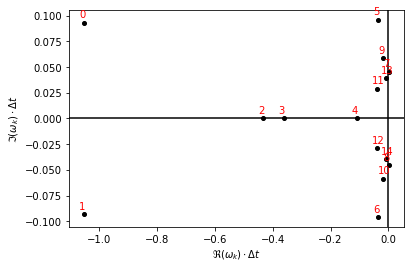

In [12]:
##  DMD ON THE FULL MATRIX

Y = u_vec[:,:-1]
Y1 = u_vec[:,1:]

Phi_y, Lambda_y, b_y = DMD(Y, Y1, r)
u_vec_dmd, Omega_y = forecastDMD(Phi_y, Lambda_y, b_y, t_full)
u_dmd = u_vec_dmd.reshape((n_x, n_y, len(t_full)))
u_dmd = np.real(u_dmd)

omega_y = np.diag(Omega_y)
omega_a_y = omega_y*(t[1]-t[0])

fig_2, ax_2 = plt.subplots()
ax_2.plot(np.real(omega_a_y), np.imag(omega_a_y), 'ko', markersize=4)
ax_2.axhline(y=0, color="black", linestyle="-")
ax_2.axvline(x=0, color="black", linestyle="-")
for i in range(len(omega_a_y)):
    plt.annotate(r'{}'.format(i), xy=(np.real(omega_a_y[i]), np.imag(omega_a_y[i])), \
        xytext=(-5,5), textcoords='offset points', color='r')
ax_2.set(xlabel= r'$\Re{({\omega}_k)} \cdot \Delta t$', ylabel= r'$\Im{({\omega}_k)} \cdot \Delta t$')

plt.show()


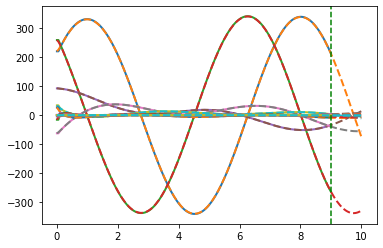

In [13]:
##  DMD ON THE LOW-RANK PROJECTION MATRIX

u_tilde_lr = np.diag(S_u_lr) @ Vt_u_lr
X = u_tilde_lr[:,:-1]
X1 = u_tilde_lr[:,1:]

Phi, Lambda, b = DMD(X, X1, r)
u_tilde_dmd, Omega = forecastDMD(Phi, Lambda, b, t_full)

omega = np.diag(Omega)
omega_a = omega*(t[1]-t[0])

fig_5, ax_5 = plt.subplots()
[ax_5.plot(t, u_tilde_lr[point,:], '-', t_full, u_tilde_dmd[point,:], '--',\
    linewidth=2,label='mode {}'.format(point+1)) for point in range(u_tilde_dmd.shape[0])]
ax_5.axvline(x=t[-1], color="green", linestyle="--")


u_pred_vec = U_u_lr @ u_tilde_dmd
u_pred = u_pred_vec.reshape((n_x, n_y, len(t_full)))
u_pred = np.real(u_pred)

plt.show()

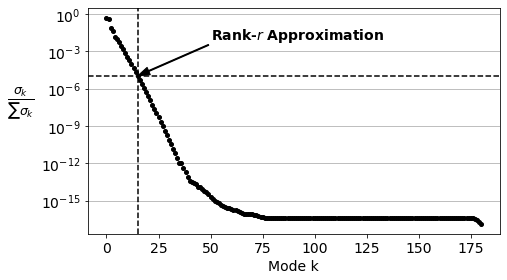

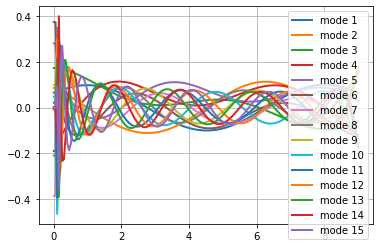

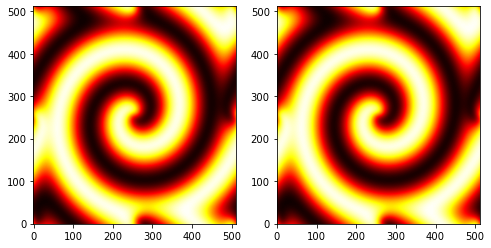

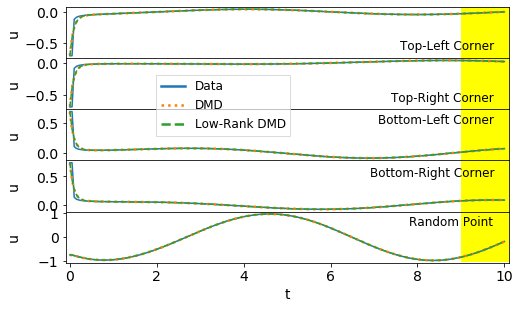

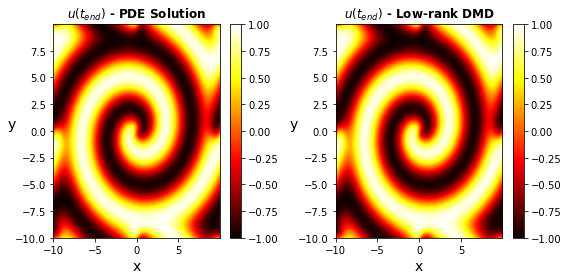

In [14]:
##  PART II - PLOTS

fig_1, ax_1 = plt.subplots(figsize=plt.figaspect(0.56), tight_layout=True)
ax_1.semilogy(S_u/np.sum(S_u), 'k.', markersize=8)
ax_1.axhline(y=S_u[r]/np.sum(S_u), color="black", linestyle="--")
ax_1.axvline(x=r, color="black", linestyle="--")
plt.annotate(r'Rank-$r$ Approximation', xy=(r,S_u[r]/np.sum(S_u)), \
        xytext=(50,0.01),color='k', fontsize=14, fontweight='bold',\
        arrowprops=dict(facecolor='black', shrink=0.0001, width=1, headwidth=8)) #textcoords='offset points', 
ax_1.set_xlabel(xlabel='Mode k', fontsize=14)
ax_1.set_ylabel(ylabel= r'$ \frac{{\sigma}_k}{\sum {\sigma}_k} $', fontsize=18, rotation=0, labelpad=20)
ax_1.tick_params(axis='x', labelsize=14)
ax_1.tick_params(axis='y', labelsize=14)
ax_1.grid(axis='y')
#fig_1.savefig('..\\report_latex\\es2.2_full_matrix_svd.eps', transaprent=True)

fig_2 = plt.figure()
ax_2 = fig_2.add_subplot(111)
[ax_2.plot(t, Vt_u_lr[k,:],linewidth=2,label='mode {}'.format(k+1)) for k in range(len(Vt_u_lr[:,0]))]
ax_2.legend()
ax_2.grid()


fig_0, ax_0 = plt.subplots(1,2,figsize=plt.figaspect(0.5))
ax_0[0].imshow(u[:,:,-1], cmap='hot', aspect='auto', interpolation='bilinear', origin='lower',\
                    vmin=np.amin(u), vmax=np.amax(u))
ax_0[1].imshow(u_lr[:,:,-1], cmap='hot', aspect='auto', interpolation='bilinear', origin='lower',\
                    vmin=np.amin(u_lr), vmax=np.amax(u_lr))



fig_3, ax_3 = plt.subplots(5,1,figsize=1.1*plt.figaspect(0.6), tight_layout=True, sharex='all',gridspec_kw={'hspace': 0})
l1=ax_3[0].plot(t_full, u_full[0,0,:], '-', linewidth=1.5, label='Data')
l2=ax_3[0].plot(t_full, u_dmd[0,0,:], ':', linewidth=2.5, label='DMD')
l3=ax_3[0].plot(t_full, u_pred[0,0,:], '--', linewidth=1.5, label='Low-Rank DMD')
rect1 = patches.Rectangle((t[-1],-1), 10, 10, color='yellow')
ax_3[0].add_patch(rect1)
ax_3[0].tick_params(axis='y', labelsize=14)
ax_3[0].annotate('Top-Left Corner', xy=(7.6,-0.6), \
        xytext=(0,0), textcoords='offset points',color='k', fontsize=12) 
ax_3[0].set_ylabel(ylabel='u', fontsize=14)
ax_3[0].get_yaxis().set_label_coords(-0.1,0.5)


ax_3[1].plot(t_full, u_full[0,-1,:], '-', linewidth=1.5)
ax_3[1].plot(t_full, u_dmd[0,-1,:], ':', linewidth=2.5)
ax_3[1].plot(t_full, u_pred[0,-1,:], '--', linewidth=1.5)
rect2 = patches.Rectangle((t[-1],-1), 10, 10, color='yellow')
ax_3[1].add_patch(rect2)
ax_3[1].tick_params(axis='y', labelsize=14)
ax_3[1].annotate('Top-Right Corner', xy=(7.4,-0.6), \
        xytext=(0,0), textcoords='offset points',color='k', fontsize=12)
ax_3[1].set_ylabel(ylabel='u', fontsize=14)
ax_3[1].get_yaxis().set_label_coords(-0.1,0.5)

ax_3[2].plot(t_full, u_full[-1,0,:], '-', linewidth=1.5)
ax_3[2].plot(t_full, u_dmd[-1,0,:], ':', linewidth=2.5)
ax_3[2].plot(t_full, u_pred[-1,0,:], '--', linewidth=1.5)
rect3 = patches.Rectangle((t[-1],-1), 10, 10, color='yellow')
ax_3[2].add_patch(rect3)
ax_3[2].tick_params(axis='y', labelsize=14)
ax_3[2].annotate('Bottom-Left Corner', xy=(7.1,0.5), \
        xytext=(0,0), textcoords='offset points',color='k', fontsize=12)
ax_3[2].set_ylabel(ylabel='u', fontsize=14)
ax_3[2].get_yaxis().set_label_coords(-0.1,0.5)

ax_3[3].plot(t_full, u_full[-1,-1,:], '-', linewidth=1.5)
ax_3[3].plot(t_full, u_dmd[-1,-1,:], ':', linewidth=2.5)
ax_3[3].plot(t_full, u_pred[-1,-1,:], '--', linewidth=1.5)
rect4 = patches.Rectangle((t[-1],-1), 10, 10, color='yellow')
ax_3[3].add_patch(rect4)
ax_3[3].tick_params(axis='y', labelsize=14)
ax_3[3].annotate('Bottom-Right Corner', xy=(6.9,0.5), \
        xytext=(0,0), textcoords='offset points',color='k', fontsize=12)

ax_3[3].set_ylabel(ylabel='u', fontsize=14)
ax_3[3].get_yaxis().set_label_coords(-0.1,0.5)

ax_3[4].plot(t_full, u_full[25,30,:], '-', linewidth=1.5)
ax_3[4].plot(t_full, u_dmd[25,30,:], ':', linewidth=2.5)
ax_3[4].plot(t_full, u_pred[25,30,:], '--', linewidth=1.5)
rect5 = patches.Rectangle((t[-1],-1), 10, 10, color='yellow')
ax_3[4].add_patch(rect5)
ax_3[4].tick_params(axis='y', labelsize=14)
ax_3[4].annotate('Random Point', xy=(7.8,0.5), \
        xytext=(0,0), textcoords='offset points',color='k', fontsize=12)
ax_3[4].set_ylabel(ylabel='u', fontsize=14)
ax_3[4].get_yaxis().set_label_coords(-0.1,0.5)

ax_3[0].set_xlim([-0.1,10.1])
ax_3[4].set_xlabel(xlabel='t', fontsize=14)
ax_3[4].tick_params(axis='x', labelsize=14)
leg = fig_3.legend( loc=[0.3,0.56], framealpha=0.7, fontsize=12, shadow=False, fancybox=False, markerscale=1.5) #bbox_to_anchor=[0, 1],
leg_lines = leg.get_lines()
plt.setp(leg_lines, linewidth=2.5)
#fig_3.savefig('..\\report_latex\\es2.2_point_comparison.eps', transaprent=True)


fig_4, ax_4 = plt.subplots(1,2,figsize=plt.figaspect(0.5), tight_layout=True)

r = ax_4[0].imshow(u_full[:,:,-1], cmap='hot', aspect='auto', interpolation='bilinear', origin='lower',vmin=np.amin(u_full), vmax=np.amax(u_full), extent=[x[0][0],x[0][-1],y[0][0],y[0][-1]])
ax_4[0].set_title(r'$u(t_{end})$ - PDE Solution', fontweight='bold')
fig_4.colorbar(r,ax=ax_4[0])
ax_4[0].set_xlabel(xlabel='x', fontsize=14)
ax_4[0].set_ylabel(ylabel='y', fontsize=14, rotation =0)

l = ax_4[1].imshow(u_pred[:,:,-1], cmap='hot', aspect='auto', interpolation='bilinear', origin='lower', vmin=np.amin(u_pred), vmax=np.amax(u_pred),  extent=[x[0][0],x[0][-1],y[0][0],y[0][-1]])
ax_4[1].set_title(r'$u(t_{end})$ - Low-rank DMD', fontweight='bold')
fig_4.colorbar(l,ax=ax_4[1])
ax_4[1].set_xlabel(xlabel='x', fontsize=14)
ax_4[1].set_ylabel(ylabel='y', fontsize=14, rotation =0)
#fig_4.savefig('..\\report_latex\\es2.2_surf_comparison.eps', transaprent=True)

plt.show()
